In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
from bimpcc.models.tvdenoising_model import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [26]:
scale = 40

In [27]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(39.5), np.float64(39.5), np.float64(-0.5))

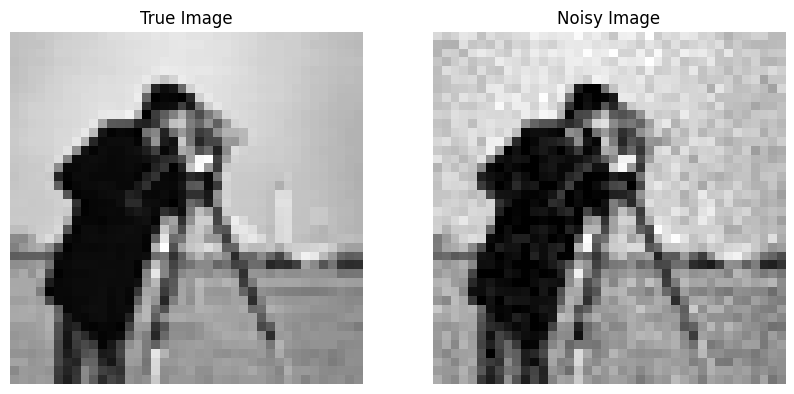

In [28]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [29]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [30]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    26404
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     4721
                     variables with only lower bounds:     1601
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4720
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8040531e+00 1.10e-02 6.11e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [31]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

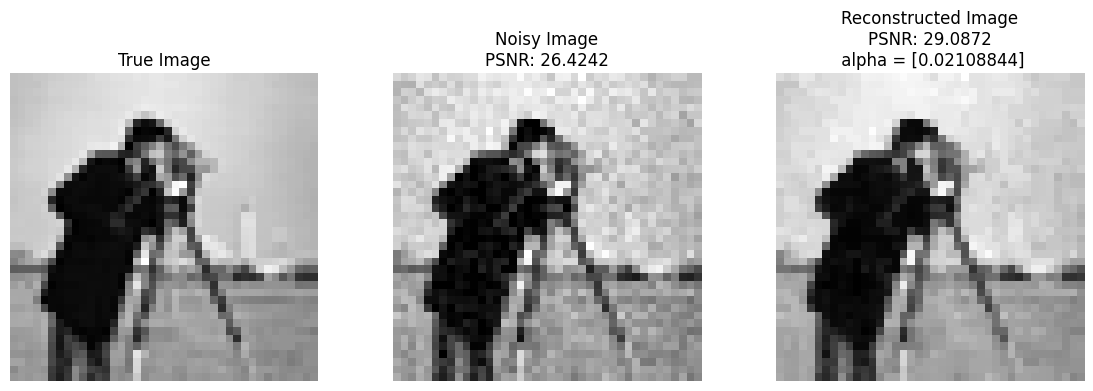

In [32]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [33]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ
# theta0 = np.zeros(n)

In [34]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [35]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
print(x0_mpcc)

[ 0.81417019  0.77723977  0.80216337 ... -2.66508973 -0.69330214
  0.02108844]


In [36]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3)

In [37]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=300,tol=1e-4,print_level=0,verbose=True,beta=0.7)

Iter   Termination_status            Objective      MPCC_compl               t

0                 0  0.24166271297857142     7.282533023725065                  1.0

1                 0  0.23582698389910234     7.26453388753287                   0.7

2                 0  0.23571318315471063     7.017386219621605       0.48999999999999994

3                 0  0.2357152834663497      6.263145179765682       0.3429999999999999

4                 0  0.2361542930940776      5.333643547572984       0.24009999999999992

5                 0  0.23738776304958972     4.675666459117697       0.16806999999999994

6                 0  0.23957956687669973     3.7358081488559396      0.11764899999999995

7                 0  0.2444443414023678      2.899802425499071       0.08235429999999996

8                 0  0.25981001167238715     2.3646877865077847      0.05764800999999997

9                 0  0.2840786403849715      1.9554566325977536      0.04035360699999998

10                 0  0.3133006620657243      1.5663364230952177      0.028247524899999984

11                 0  0.3506778789778847      1.3051973442019196      0.019773267429999988

12                 0  0.39531993013125166     1.0708256130657154      0.01384128720099999

13                 0  0.44855466372256714     0.8922241059650087      0.009688901040699992

14                 0  0.5078603892605738      0.7507091829688446      0.006782230728489994

15                 0  0.5699802113731187      0.6200893299952295      0.004747561509942996

16                 0  0.631326575670136       0.5182245204722112      0.003323293056960097

17                 0  0.688448540298303       0.4367981545752375      0.002326305139872068

18                 1  0.7399364951595265      0.3714636406648407      0.0016284135979104473

19                 0  0.7858997389138568      0.3165660127217242      0.001139889518537313

20                 0  0.8262723971068399      0.26721475477882534     0.000797922662976119

21                 0  0.8601068420158073      0.23016216012011256     0.0005585458640832833

22                 0  0.8877807503394356      0.1934275489799969      0.00039098210485829826

23                 0  0.910072723137061       0.15858776527478202     0.0002736874734008088

24                 0  0.9277728534037883      0.12848803092329822     0.00019158123138056615

25                 0  0.9417805627618766      0.10421410366345502     0.00013410686196639628

26                 0  0.9527367854741542      0.08468683374488642     9.387480337647739e-05

27                 0  0.9611775103646668      0.06719350715232518     6.571236236353417e-05

28                 0  0.967622422389183       0.053605962939340515    4.5998653654473914e-05

29                 0  0.9725417259827089      0.042442025079314126    3.219905755813174e-05

30                 0  0.9762747748142754      0.03330239000534672     2.2539340290692216e-05

31                 0  0.9790833817145655      0.025354507760273304    1.577753820348455e-05

32                 0  0.9811821463061472      0.0198610012536578      1.1044276742439186e-05

Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 0.9811821463061472
       x: [ 8.140e-01  7.772e-01 ... -6.935e-01  2.123e-02]
     nit: 102
    info:     status: 0
                   x: [ 8.140e-01  7.772e-01 ... -6.935e-01  2.123e-02]
                   g: [-9.901e-09 -9.803e-09 ...  1.526e-13  2.656e-13]
             obj_val: 0.9811821463061472
              mult_g: [-1.008e-01 -5.084e-02 ... -2.651e-02 -1.581e-02]
            mult_x_L: [ 1.229e-11  1.287e-11 ...  0.000e+00  4.710e-10]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 103
    njev: 104

Intermediate fn: 0.9811821463061472

complementarity: 0.0198610012536578

* (STOPPED) Iteration 34: Solving the NLP problem for t = 1e-05 with complementarity: 0.0198610012536578

In [38]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

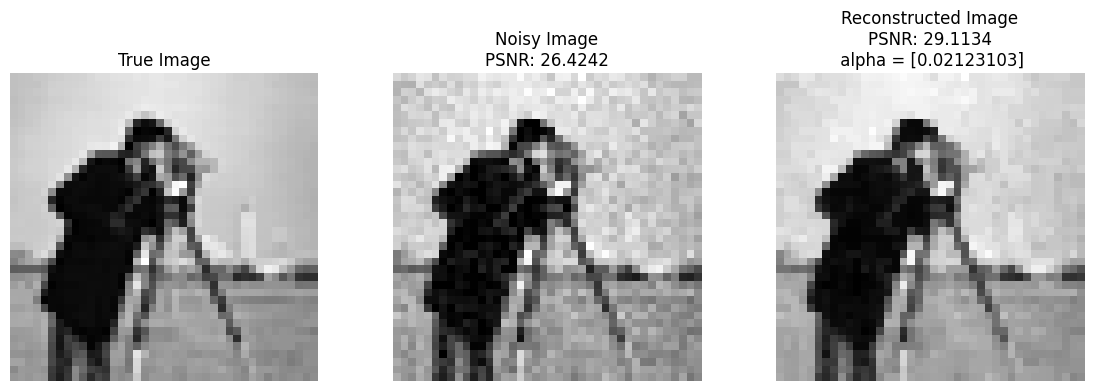

In [39]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)